In [ ]:
from PIL import Image
import numpy as np
import collections
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2 as cv

plotno = 1

In [ ]:
def preprocess_img(im_in):
  original_image = Image.open(im_in)
  resized_image = original_image.resize((256, 256))
  im = np.array(resized_image.convert('L'))
  im_uint8 = ((im - np.min(im)) * (1/(np.max(im) - np.min(im)) * 255)).astype('uint8')
  return im_uint8

In [ ]:
def find_missing(lst):
  return [i for x, y in zip(lst, lst[1:]) for i in range(x + 1, y) if y - x > 1]

In [ ]:
def create_pdf(im_in):
  cv2_imshow(im_in)
  freq = {}
  for i in im_in:
    for j in i:
      if j not in freq:
        freq[j] = 1
      else:
        freq[j] += 1
  freq = collections.OrderedDict(sorted(freq.items()))
  missing = find_missing(list(freq.keys()))
  for i in missing:
    freq[i] = 0
  freq = collections.OrderedDict(sorted(freq.items()))
  intensities = list(freq.keys())
  frequencies = list(freq.values())
  pdf = []
  total = sum(frequencies)
  for i in frequencies:
    pdf.append(i/total)
  return pdf, intensities, frequencies

In [ ]:
def create_cdf(pdf):
  total = 0
  cdf = []
  for i in pdf:
    total += i
    cdf.append(total)
  return cdf

In [ ]:
def plot(l1, l2, plotno):
  plt.bar(l1, l2)
  plt.show()
  plt.savefig('plot' + str(plotno) + '.png')
  return plotno + 1

In [ ]:
def histogram_equalization(im_in, plotno):
  pdf, intensities, frequencies = create_pdf(im_in)
  cdf = create_cdf(pdf)
  L = len(intensities)
  op_intensities = []
  for i in cdf:
    op_intensities.append(round(i*(L-1)))
  equalized_im = im_in
  for i in range(len(im_in)):
    for j in range(len(im_in[i])):
      x = im_in[i][j]
      if x+1 < len(op_intensities):
        equalized_im[i][j] = op_intensities[x]
  cv2_imshow(equalized_im)
  plotno = plot(intensities, frequencies, plotno)
  plotno = plot(intensities, pdf, plotno)
  plotno = plot(intensities, cdf, plotno)
  return equalized_im, plotno

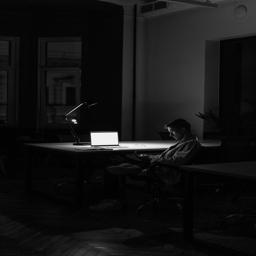

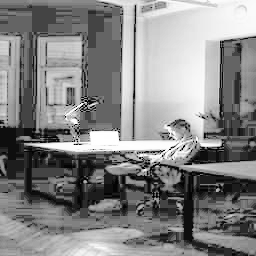

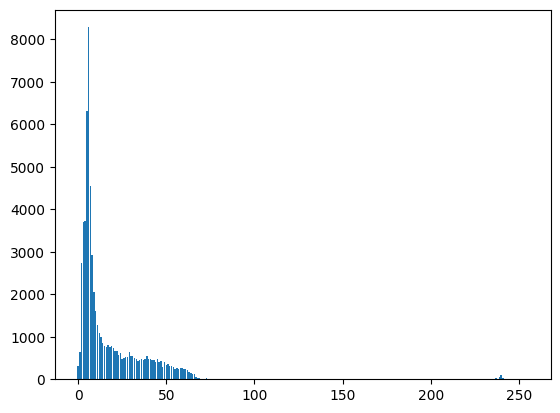

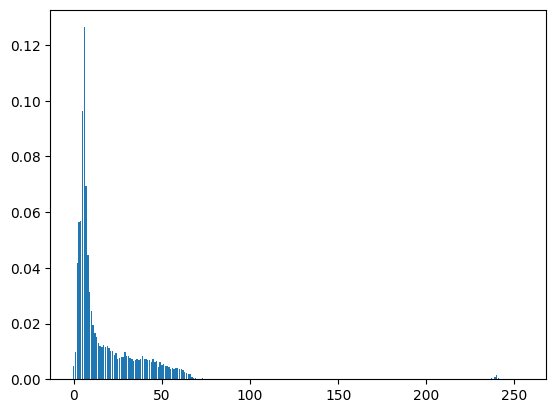

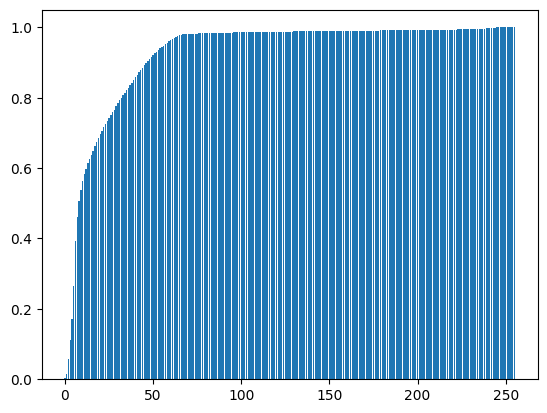

True

<Figure size 640x480 with 0 Axes>

In [ ]:
im_in = preprocess_img('indoors.png')
equalized_im, plotno = histogram_equalization(im_in, plotno)
cv.imwrite('indoors_op.png', equalized_im)

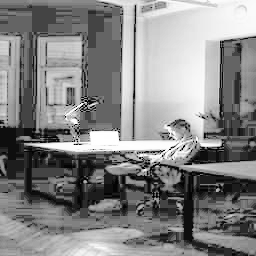

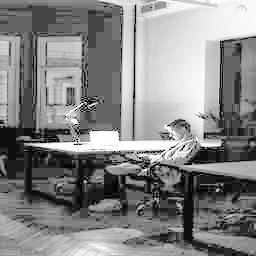

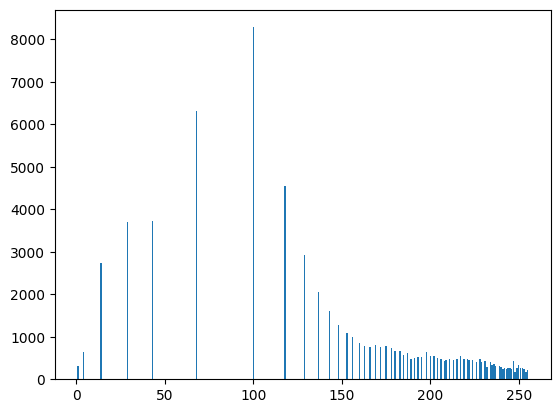

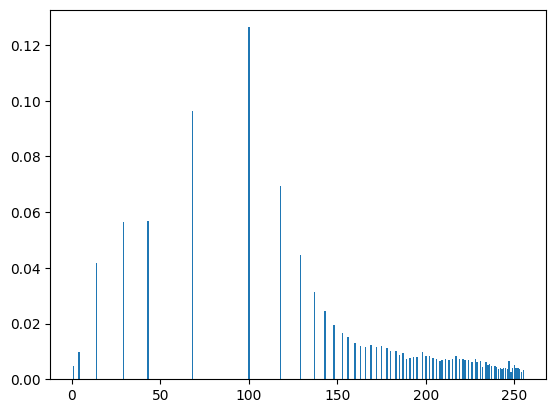

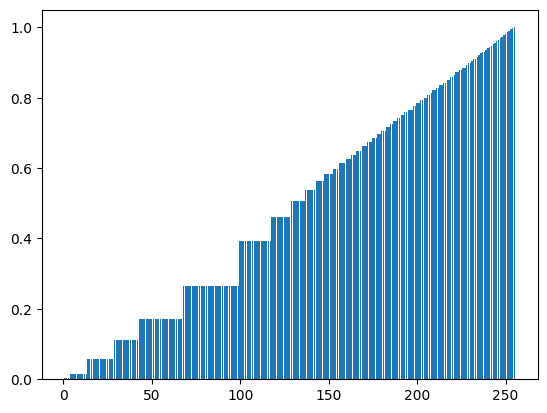

True

<Figure size 640x480 with 0 Axes>

In [ ]:
equalized_im2, plotno = histogram_equalization(equalized_im, plotno)
cv.imwrite('indoors_op2.png', equalized_im2)

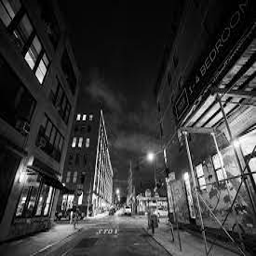

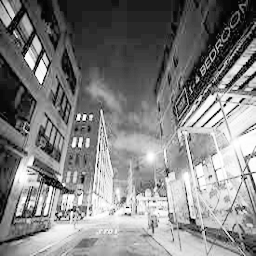

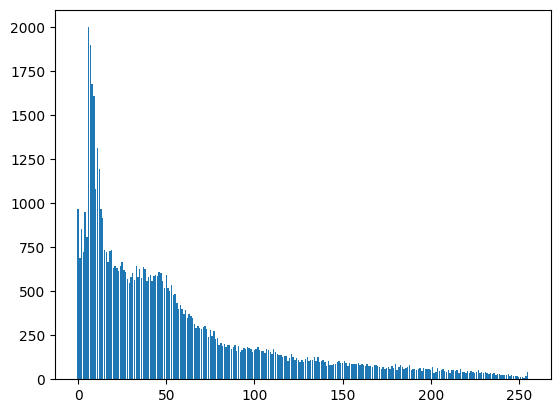

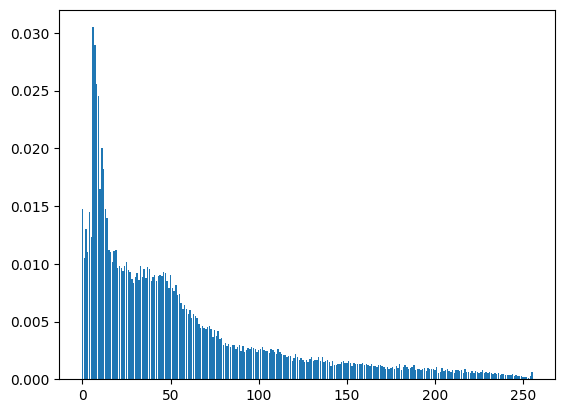

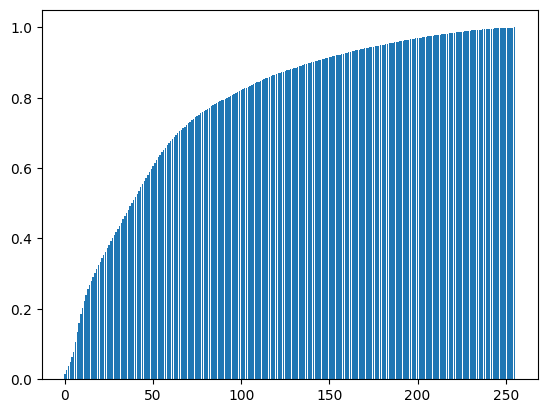

True

<Figure size 640x480 with 0 Axes>

In [ ]:
im_in = preprocess_img('test.jpg')
equalized_im, plotno = histogram_equalization(im_in, plotno)
cv.imwrite('test_op.jpg', equalized_im)

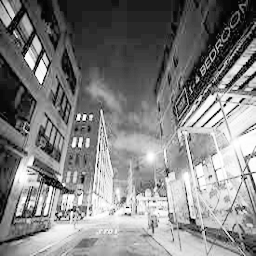

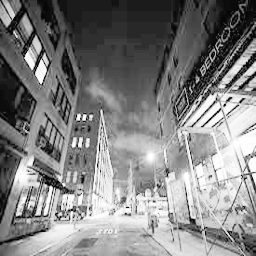

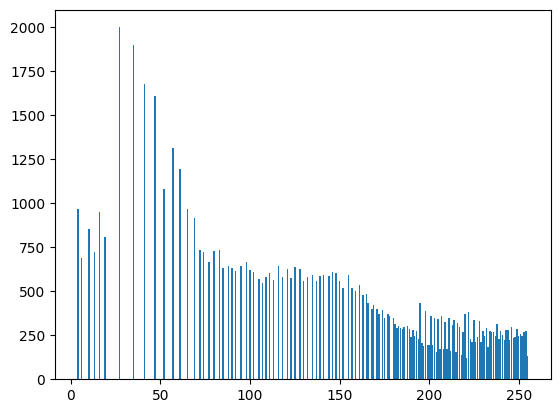

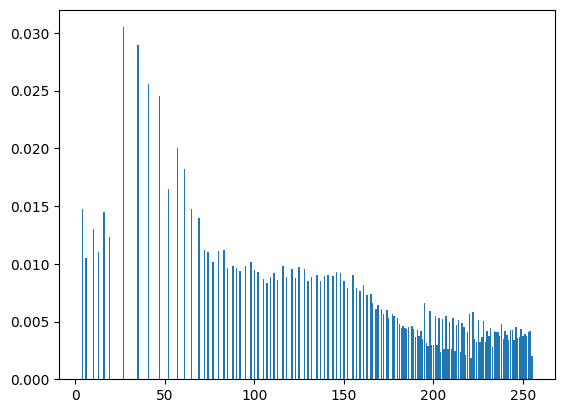

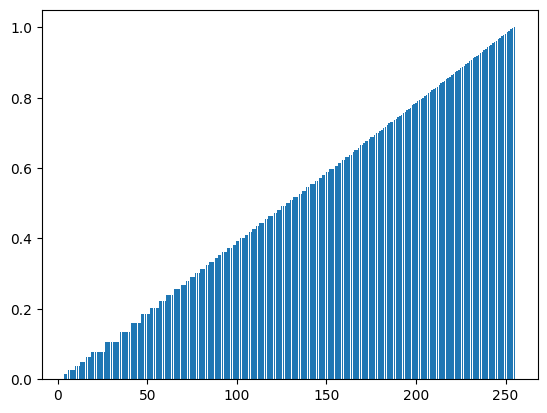

True

<Figure size 640x480 with 0 Axes>

In [ ]:
equalized_im2, plotno = histogram_equalization(equalized_im, plotno)
cv.imwrite('test_op2.jpg', equalized_im2)

In [ ]:
def manual_threshold(im_in, threshold):
  ret, thresh1 = cv.threshold(im_in, threshold, 255, cv.THRESH_BINARY)
  cv2_imshow(thresh1)
  ret, thresh1 = cv.threshold(im_in, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
  cv2_imshow(thresh1)

  ret, thresh2 = cv.threshold(im_in, threshold, 255, cv.THRESH_BINARY_INV)
  cv2_imshow(thresh2)
  ret, thresh2 = cv.threshold(im_in, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
  cv2_imshow(thresh2)

  ret, thresh3 = cv.threshold(im_in, threshold, 255, cv.THRESH_TRUNC)
  cv2_imshow(thresh3)
  ret, thresh3 = cv.threshold(im_in, 0, 255, cv.THRESH_TRUNC + cv.THRESH_OTSU)
  cv2_imshow(thresh3)

  ret, thresh4 = cv.threshold(im_in, threshold, 255, cv.THRESH_TOZERO)
  cv2_imshow(thresh4)
  ret, thresh4 = cv.threshold(im_in, 0, 255, cv.THRESH_TOZERO + cv.THRESH_OTSU)
  cv2_imshow(thresh4)

  ret, thresh5 = cv.threshold(im_in, threshold, 255, cv.THRESH_TOZERO_INV)
  cv2_imshow(thresh5)
  ret, thresh5 = cv.threshold(im_in, 0, 255, cv.THRESH_TOZERO_INV + cv.THRESH_OTSU)
  cv2_imshow(thresh5)

  manual_thresh_img = thresh1
  return manual_thresh_img

In [ ]:
def otsu_helper(threshold, pdf):
  w0, w1 = 0, 0
  for i in range(threshold):
    w0 += pdf[i]
  for i in range(threshold, len(pdf)):
    w1 += pdf[i]
  u0, u1 = 0, 0
  for i in range(threshold):
    u0 += (i * pdf[i])
  for i in range(threshold, len(pdf)):
    u1 += (i * pdf[i])
  if w0 == 0 or w1 == 0:
    return 0
  u0 /= w0
  u1 /= w1
  inter_class_var = w0 * w1 * ((u0**2) + (u1**2) - (2 * u0 * u1))
  return inter_class_var

In [ ]:
def otsu_helper2(im_in, threshold, pdf):
  N = len(im_in) * len(im_in[0])
  w0, w1, u0, u1 = 0, 0, 0, 0
  for i in range(threshold):
    w0 += pdf[i]
    u0 += (i * pdf[i])
  for i in range(threshold, len(pdf)):
    w1 += pdf[i]
    u1 += (i * pdf[i])
  if w0 == 0 or w1 == 0:
    return 0
  u0 /= w0
  u1 /= w1
  var0, var1 = 0, 0
  for i in range(threshold):
    var0 += ((i**2) + (u0**2) - (2 * i * u0)) * pdf[i]
  for i in range(threshold, len(pdf)):
    var1 += ((i**2) + (u1**2) - (2 * i * u1)) * pdf[i]
  var0 /= w0
  var1 /= w1
  w0 /= N
  w1 /= N
  var = (w0 * var0) + (w1 * var1)
  return var

In [ ]:
def otsu_threshold(im_in, plotno):
  pdf, intensities, frequencies = create_pdf(im_in)
  plotno = plot(intensities, frequencies, plotno)
  plotno = plot(intensities, pdf, plotno)
  all_intra_class_variance = [0]
  all_inter_class_variance = [0]
  for i in range(1, len(intensities)):
    all_intra_class_variance.append(otsu_helper2(im_in, i, pdf))
    all_inter_class_variance.append(otsu_helper(i, pdf))

  plotno = plot(intensities, all_intra_class_variance, plotno)
  plotno = plot(intensities, all_inter_class_variance, plotno)

  all_intra_class_variance = all_intra_class_variance[1:]
  all_inter_class_variance = all_inter_class_variance[1:]

  min_val = min(all_intra_class_variance)
  min_idx = all_intra_class_variance.index(min_val)

  max_val = max(all_inter_class_variance)
  max_idx = all_inter_class_variance.index(max_val)

  if min_idx == max_idx:
    print('Otsu Threshold: ', min_idx)
    print('Minimum Intra-Class Variance: ', min_val)
    print('Maximum Inter-Class Variance: ', max_val)
  else:
    print('ERROR')

  ret, thresh1 = cv.threshold(im_in, min_idx, 255, cv.THRESH_BINARY)
  cv2_imshow(thresh1)
  ret, thresh2 = cv.threshold(im_in, min_idx, 255, cv.THRESH_BINARY_INV)
  cv2_imshow(thresh2)
  ret, thresh3 = cv.threshold(im_in, min_idx, 255, cv.THRESH_TRUNC)
  cv2_imshow(thresh3)
  ret, thresh4 = cv.threshold(im_in, min_idx, 255, cv.THRESH_TOZERO)
  cv2_imshow(thresh4)
  ret, thresh5 = cv.threshold(im_in, min_idx, 255, cv.THRESH_TOZERO_INV)
  cv2_imshow(thresh5)

  otsu_thresh_img = thresh1
  return otsu_thresh_img, plotno

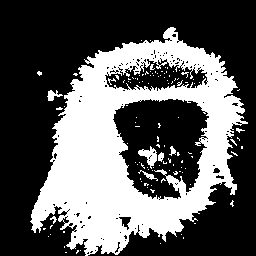

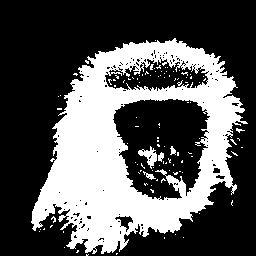

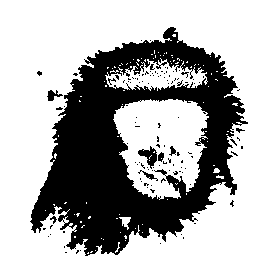

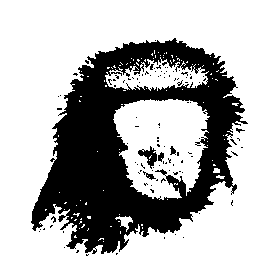

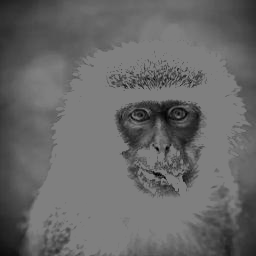

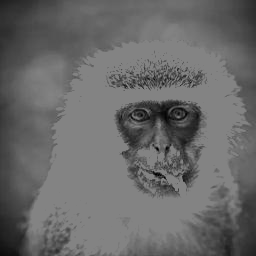

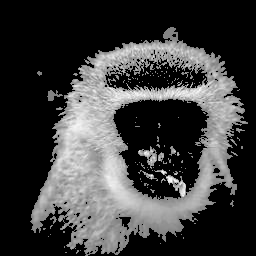

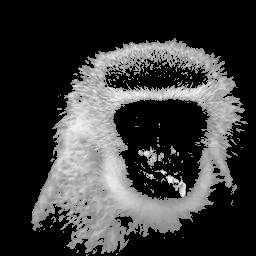

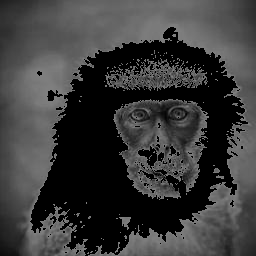

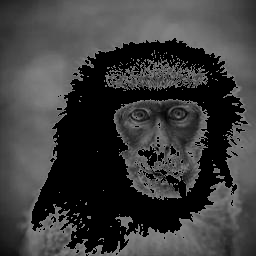

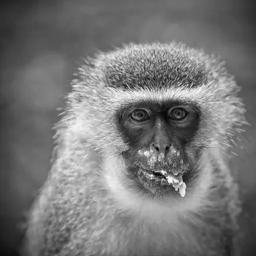

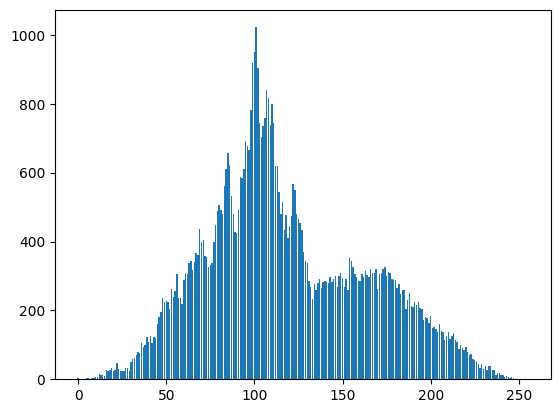

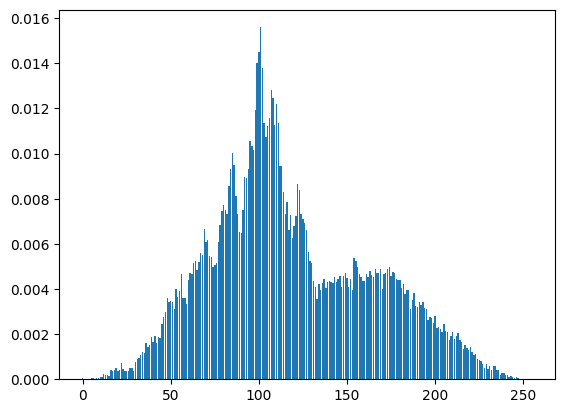

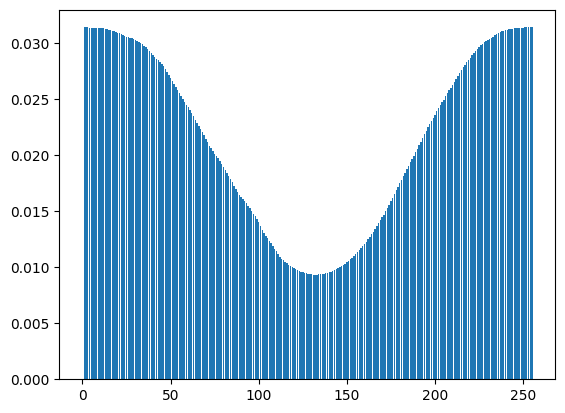

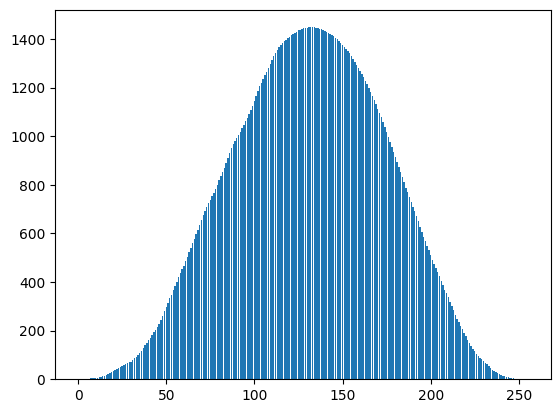

Otsu Threshold:  131
Minimum Intra-Class Variance:  0.009354531525074216
Maximum Inter-Class Variance:  1448.0136082304264


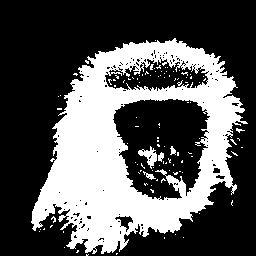

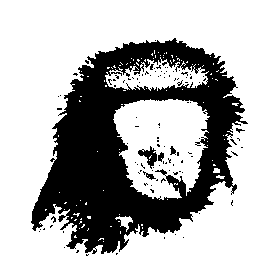

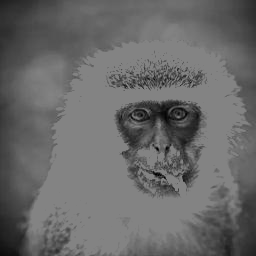

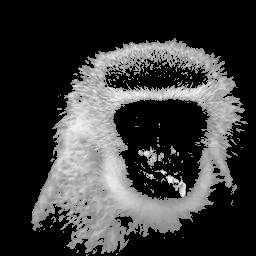

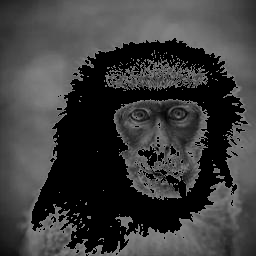

<Figure size 640x480 with 0 Axes>

In [ ]:
im_in = preprocess_img('b2_a.png')
manual_thresh_img = manual_threshold(im_in, 127)
otsu_thresh_img, plotno = otsu_threshold(im_in, plotno)

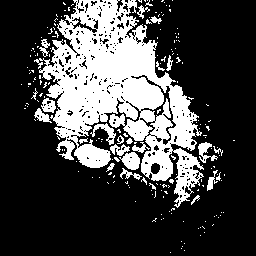

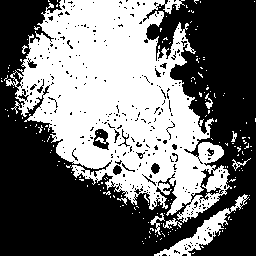

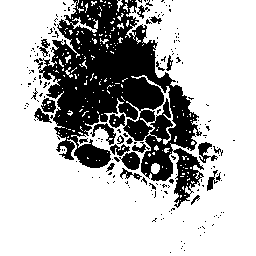

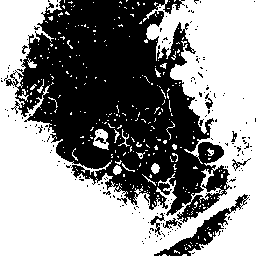

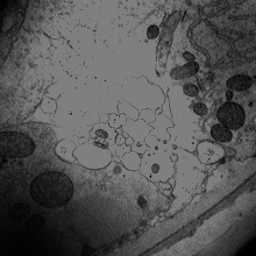

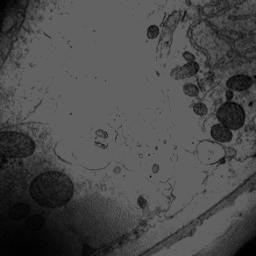

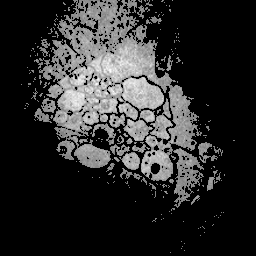

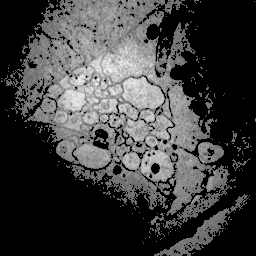

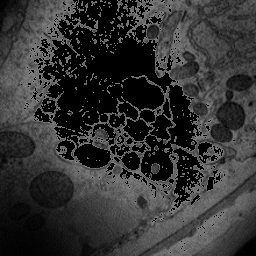

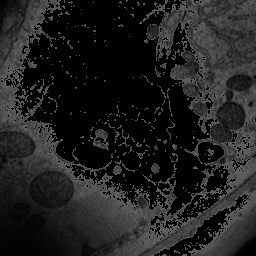

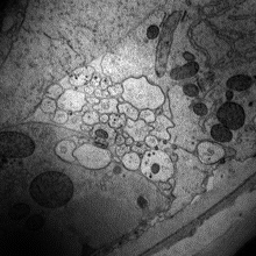

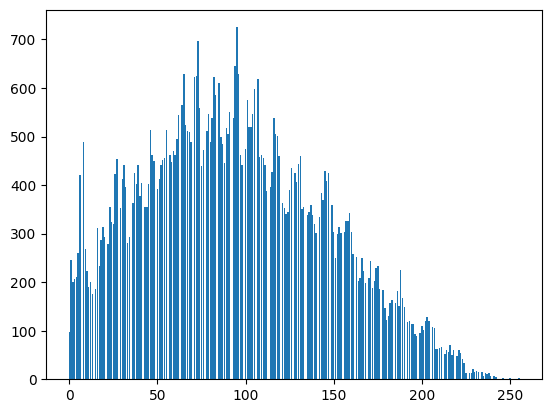

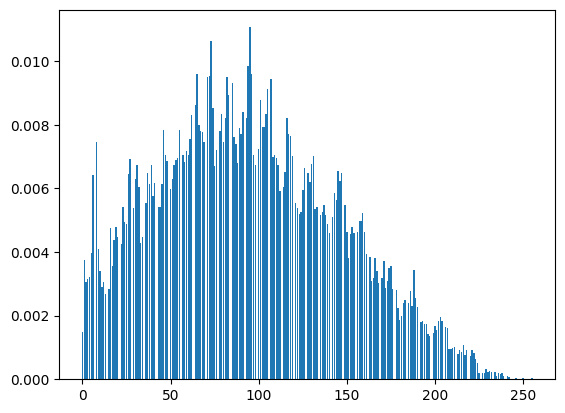

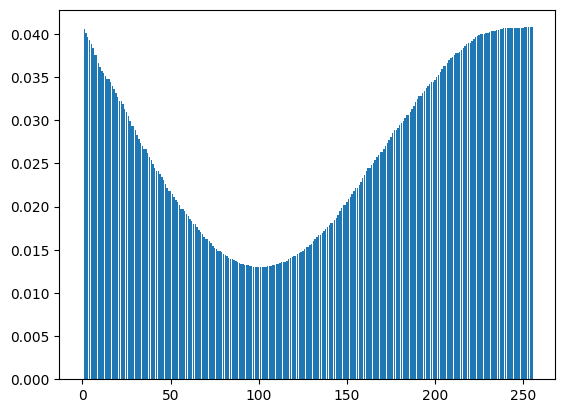

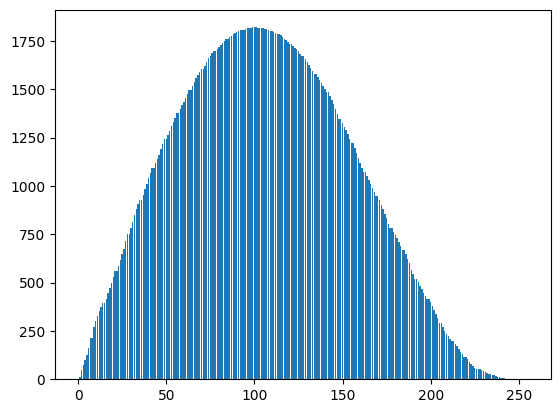

Otsu Threshold:  98
Minimum Intra-Class Variance:  0.01299592143231117
Maximum Inter-Class Variance:  1820.0308771863783


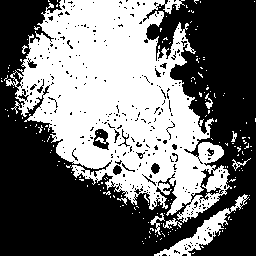

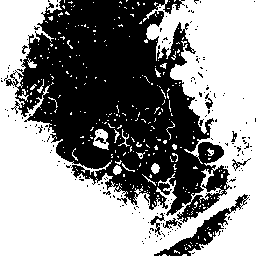

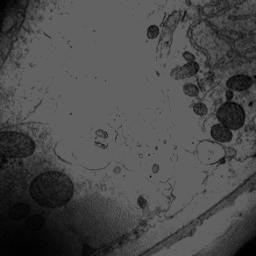

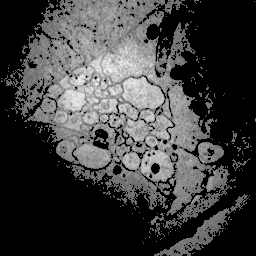

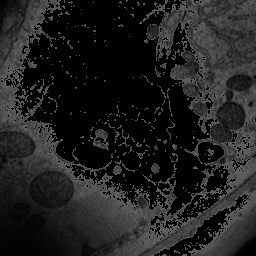

<Figure size 640x480 with 0 Axes>

In [ ]:
im_in = preprocess_img('b2_b.png')
manual_thresh_img = manual_threshold(im_in, 127)
otsu_thresh_img, plotno = otsu_threshold(im_in, plotno)

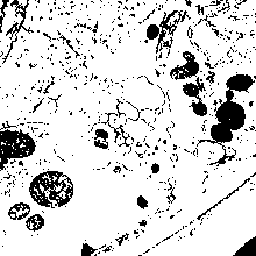

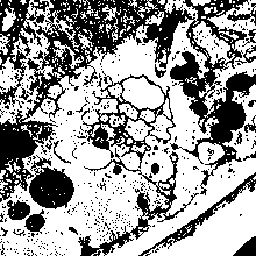

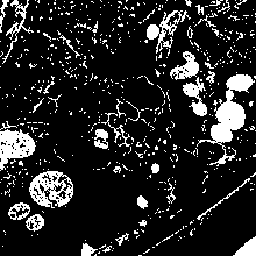

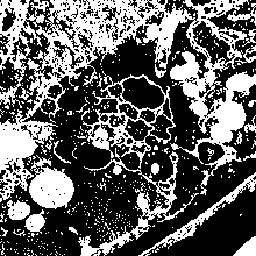

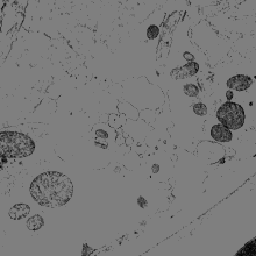

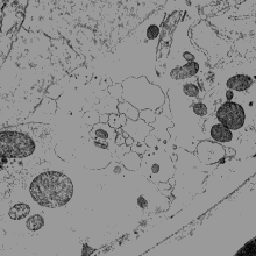

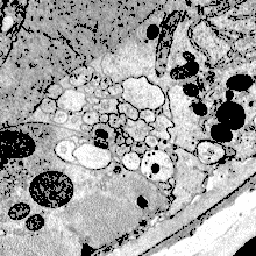

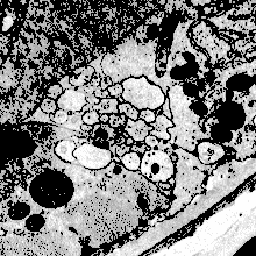

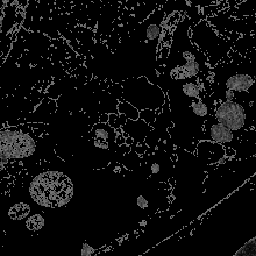

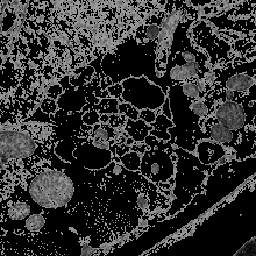

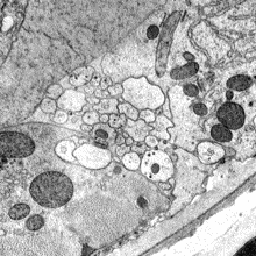

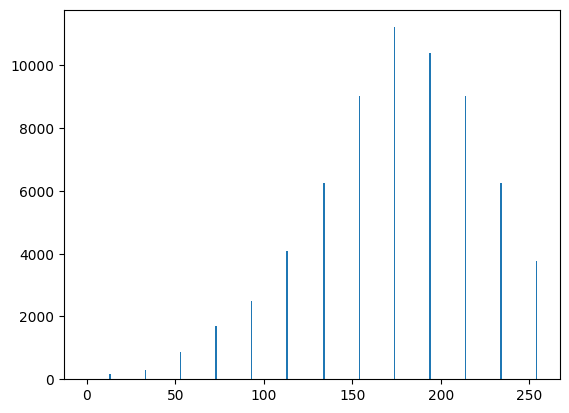

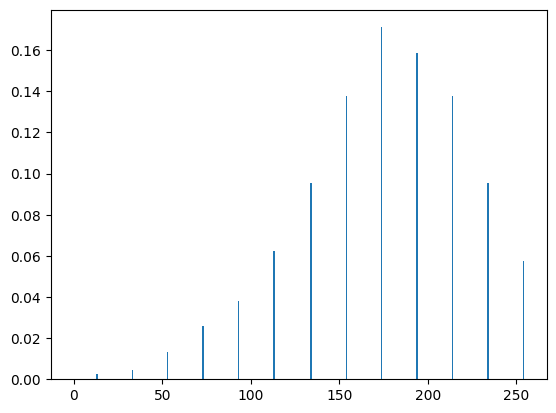

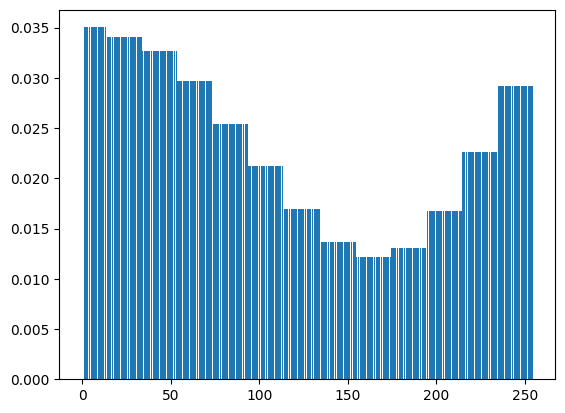

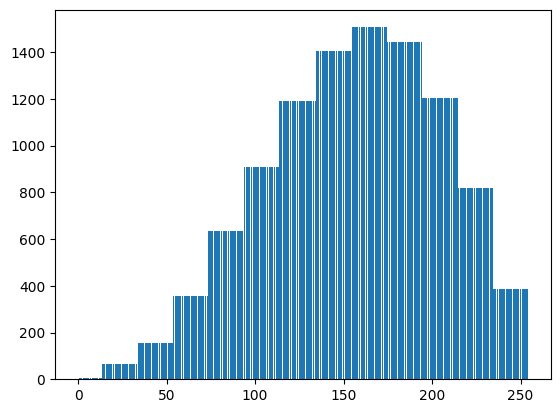

Otsu Threshold:  154
Minimum Intra-Class Variance:  0.012123562073845916
Maximum Inter-Class Variance:  1506.470214939216


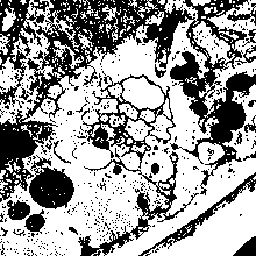

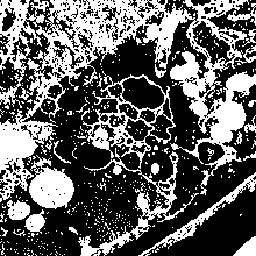

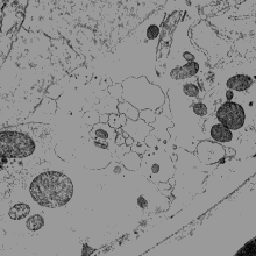

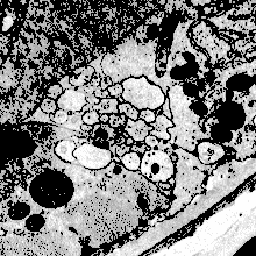

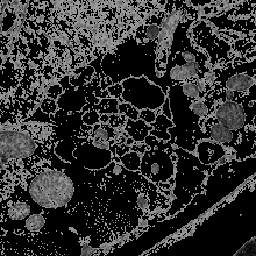

<Figure size 640x480 with 0 Axes>

In [ ]:
im_in = preprocess_img('b2_c.png')
manual_thresh_img = manual_threshold(im_in, 127)
otsu_thresh_img, plotno = otsu_threshold(im_in, plotno)

In [ ]:
def histogram_matching(src_im, trg_im, plotno):
  pdf1, intensities1, frequencies1 = create_pdf(src_im)
  cdf1 = create_cdf(pdf1)
  plotno = plot(intensities1, frequencies1, plotno)
  plotno = plot(intensities1, pdf1, plotno)
  plotno = plot(intensities1, cdf1, plotno)
  pdf2, intensities2, frequencies2 = create_pdf(trg_im)
  cdf2 = create_cdf(pdf2)
  plotno = plot(intensities2, frequencies2, plotno)
  plotno = plot(intensities2, pdf2, plotno)
  plotno = plot(intensities2, cdf2, plotno)
  matched_im = src_im
  for i in range(len(src_im)):
    for j in range(len(src_im[i])):
      diff = []
      x = src_im[i][j]
      cdf1x = cdf1[x]
      for k in cdf2:
        diff.append(abs(k - cdf1x))
      index = diff.index(min(diff))
      matched_im[i][j] = index
  pdf3, intensities3, frequencies3 = create_pdf(matched_im)
  cdf3 = create_cdf(pdf3)
  plotno = plot(intensities3, frequencies3, plotno)
  return matched_im, plotno

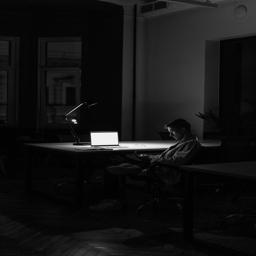

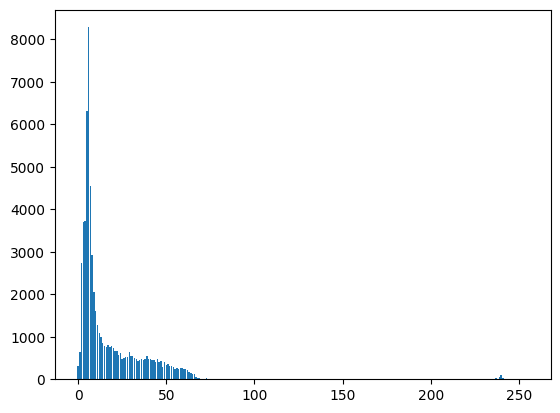

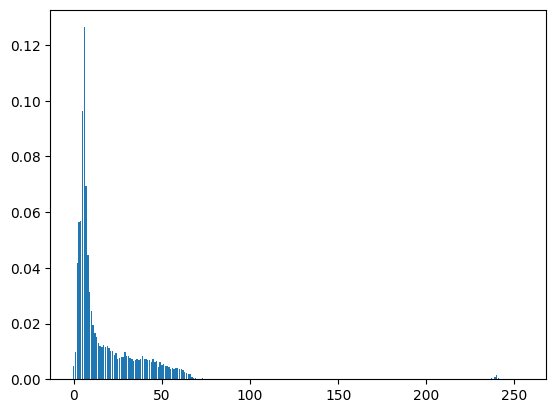

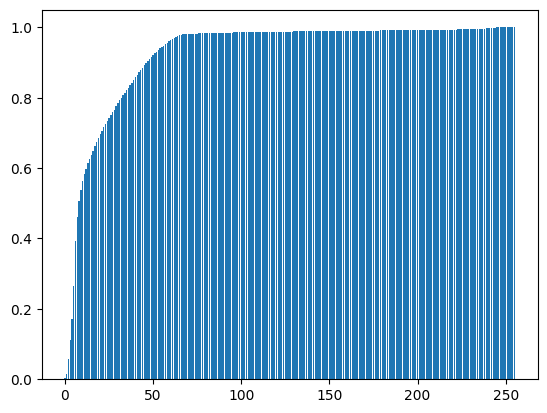

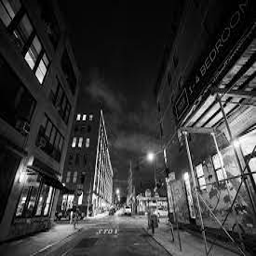

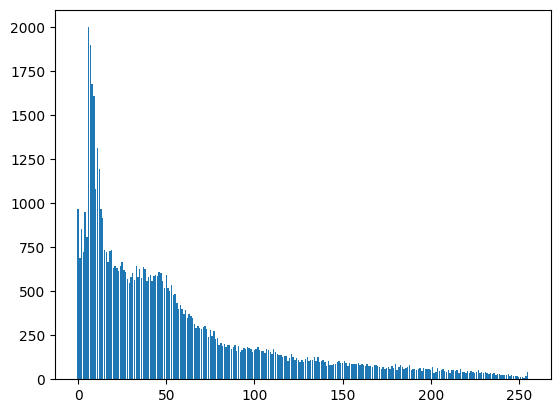

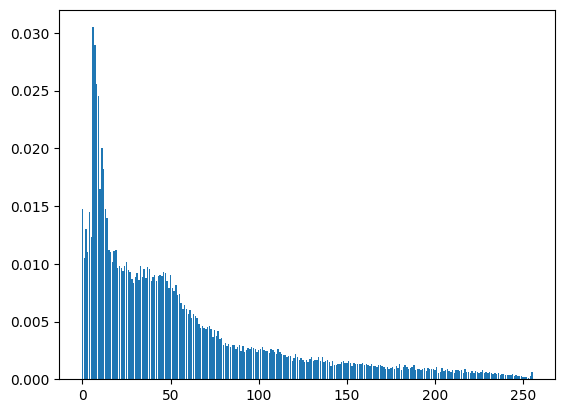

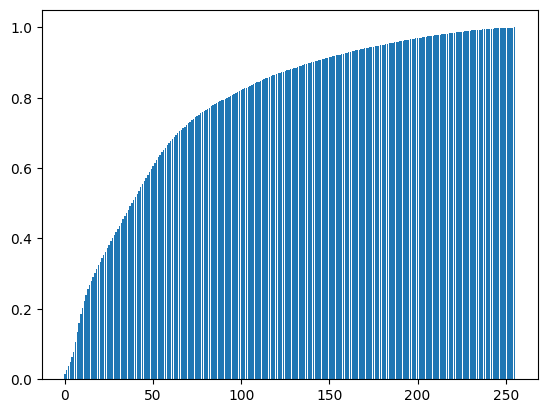

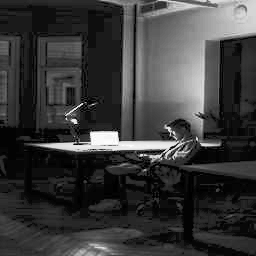

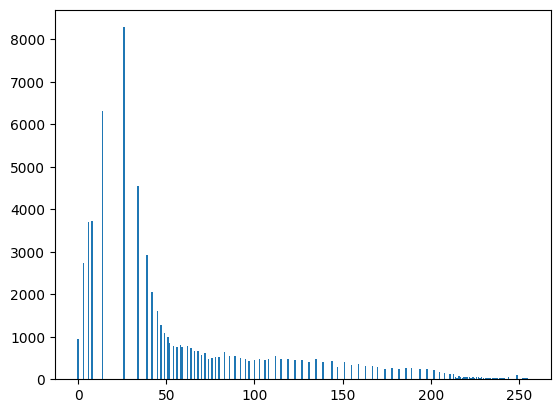

<Figure size 640x480 with 0 Axes>

In [ ]:
src_im = preprocess_img('indoors.png')
trg_im = preprocess_img('test.jpg')
matched_im, plotno = histogram_matching(src_im, trg_im, plotno)

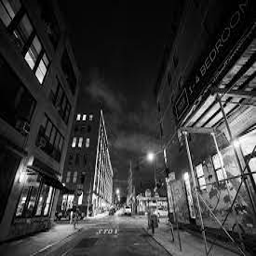

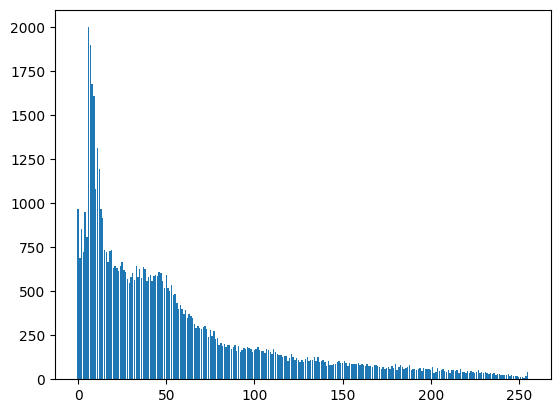

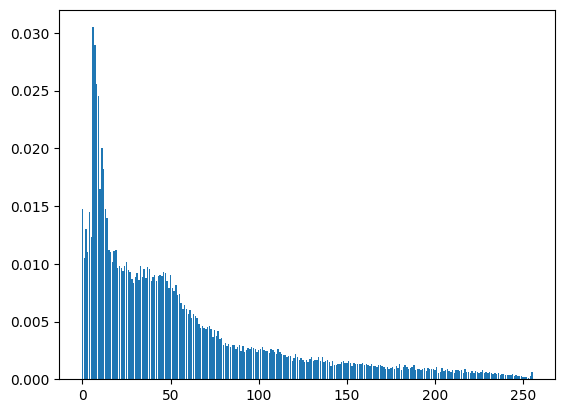

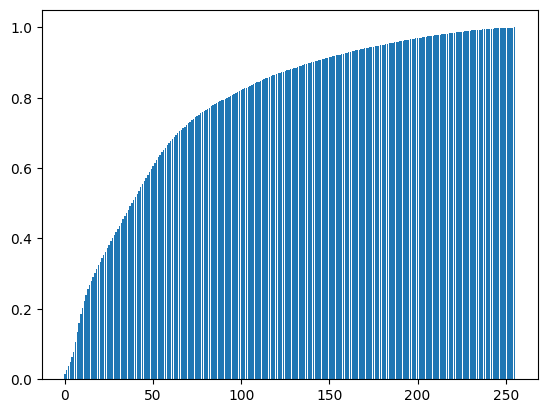

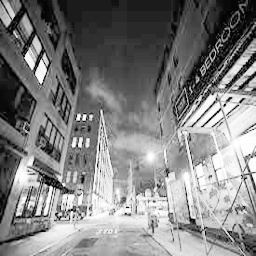

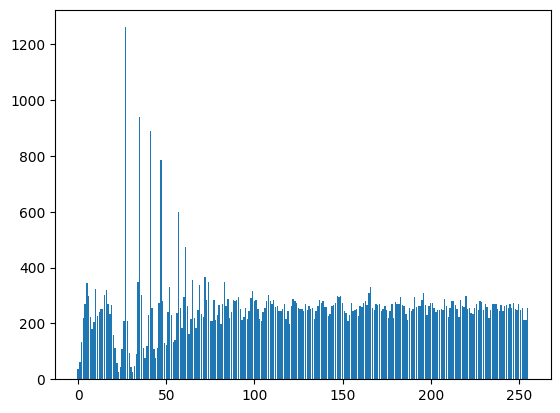

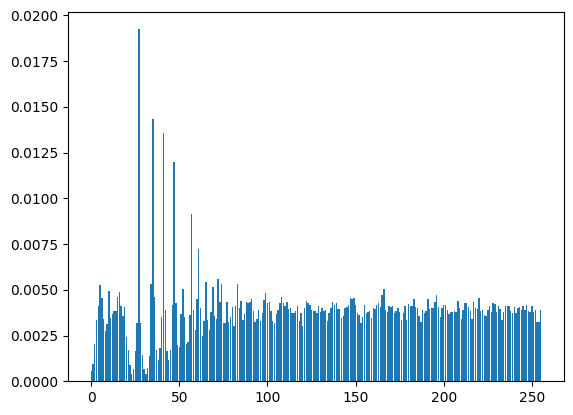

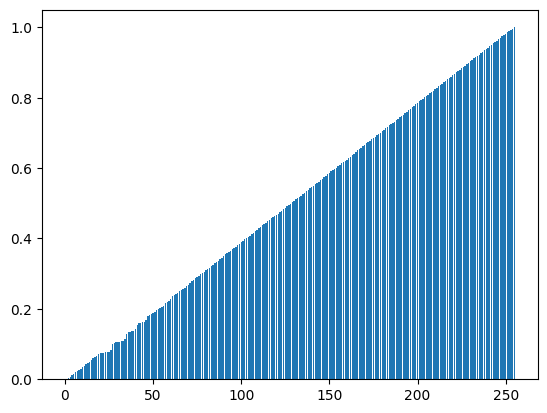

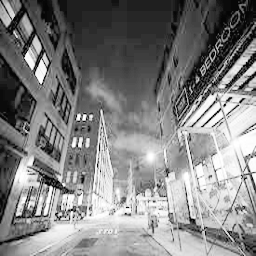

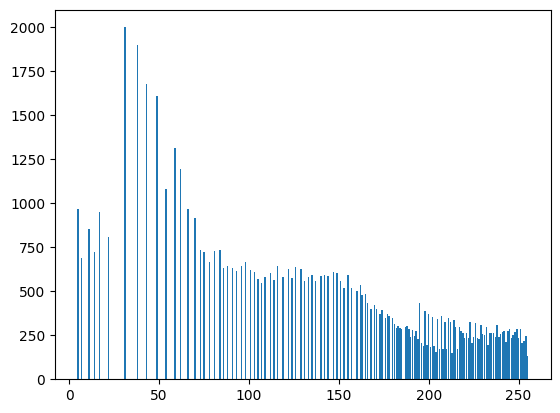

<Figure size 640x480 with 0 Axes>

In [ ]:
src_im = preprocess_img('test.jpg')
trg_im = preprocess_img('test_op.jpg')
matched_im, plotno = histogram_matching(src_im, trg_im, plotno)

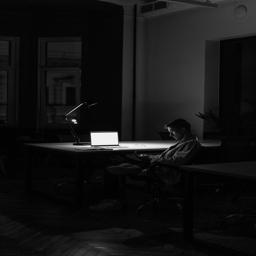

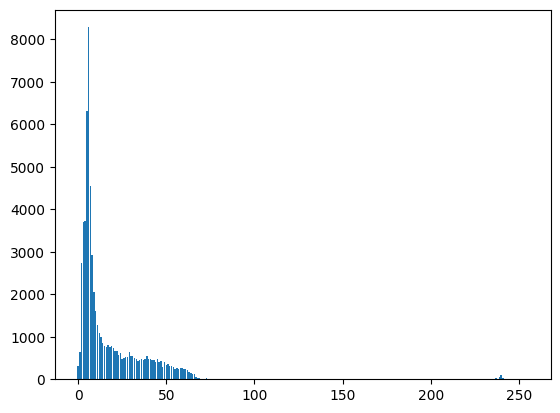

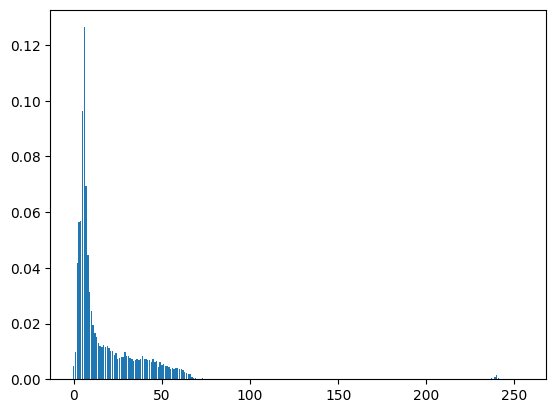

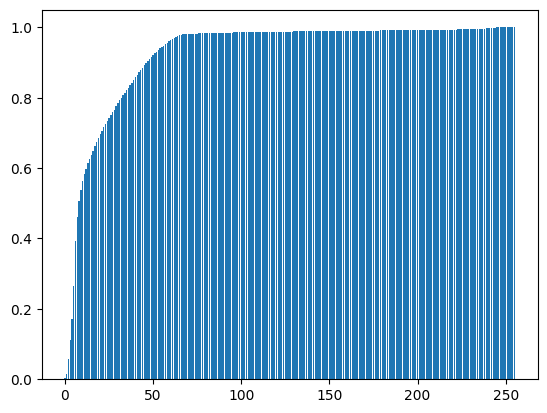

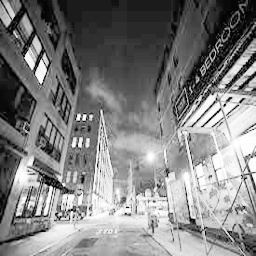

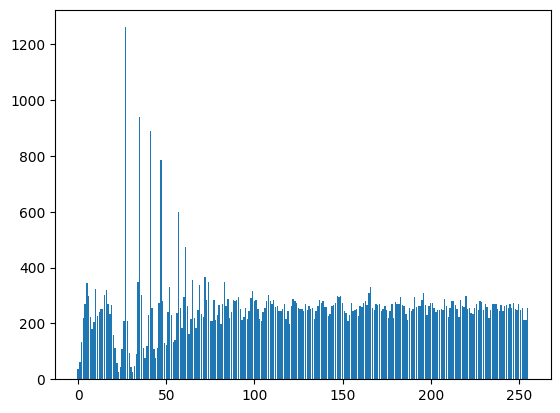

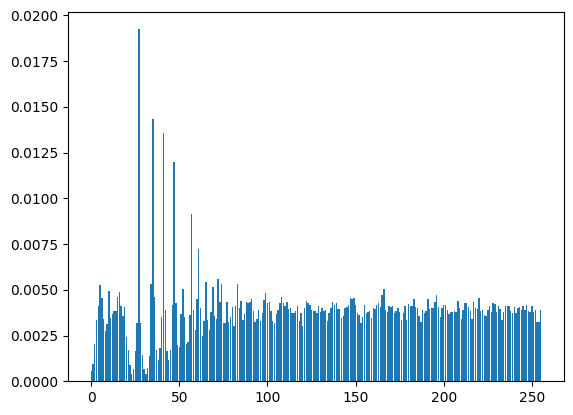

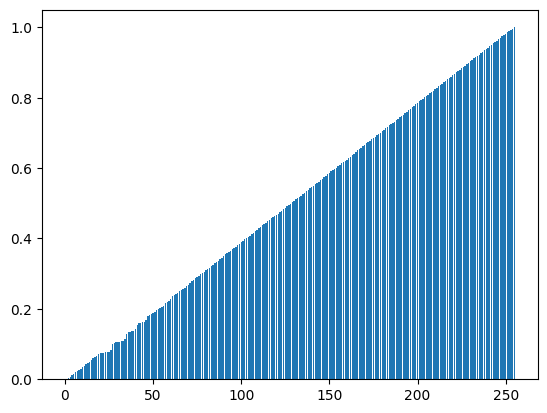

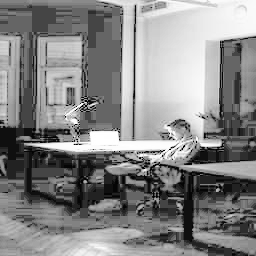

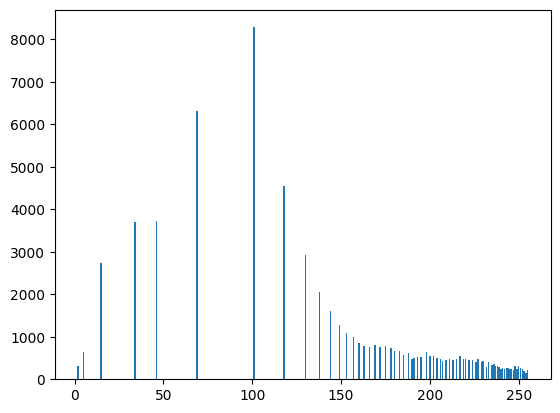

<Figure size 640x480 with 0 Axes>

In [ ]:
src_im = preprocess_img('indoors.png')
trg_im = preprocess_img('test_op.jpg')
matched_im, plotno = histogram_matching(src_im, trg_im, plotno)